In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from plot_day_precip import get_precip
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt


In [20]:
def get_data(fili, variable):
    
    ds = xr.open_dataset(fili)

    da = ds[variable]
    #da = da * 1e3 # Scale to mm
    
    # Get attributes
    da.attrs = ds[variable].attrs
    da.attrs['units'] = 'mm'

    proj = ccrs.PlateCarree()
    extent = [da.coords['lon'].values[0],
              da.coords['lon'].values[-1],
              da.coords['lat'].values[0],
              da.coords['lat'].values[-1]]
    origin = 'upper'
    
    return da, proj, extent, origin


In [4]:
def set_colormap():
    '''Defines colormap with NSW Precip colors'''
    
    colors = [
        "#04e9e7",  # 0.01 - 0.10 inches
        "#019ff4",  # 0.10 - 0.25 inches
        "#0300f4",  # 0.25 - 0.50 inches
        "#02fd02",  # 0.50 - 0.75 inches
        "#01c501",  # 0.75 - 1.00 inches
        "#008e00",  # 1.00 - 1.50 inches
        "#fdf802",  # 1.50 - 2.00 inches
        "#e5bc00",  # 2.00 - 2.50 inches
        "#fd9500",  # 2.50 - 3.00 inches
        "#fd0000",  # 3.00 - 4.00 inches
        "#d40000",  # 4.00 - 5.00 inches
        "#bc0000",  # 5.00 - 6.00 inches
        "#f800fd",  # 6.00 - 8.00 inches
        "#9854c6",  # 8.00 - 10.00 inches
        "#fdfdfd"   # 10.00+
    ]
    cmap = mcolors.ListedColormap(colors)
    cmap.set_over('white')
    cmap.set_under('white')

    return cmap


In [5]:
def set_norm(cmap):
    '''Defines a Boundary Normalization'''
    
    levels=[1., 2.5, 5., 10., 20., 30., 40.,
            50., 60., 80., 100., 125., 150.,
            200., 250., 500.]
    #levels=[5., 10., 20., 30., 40.,
    #        50., 60., 80., 100., 125., 150.,
    #        200., 250., 500.]
    return mcolors.BoundaryNorm(levels, cmap.N, clip=False)

Test cmap and norm

[[  -1.     1.5    4.     7. ]
 [  15.    25.    31.    45. ]
 [  55.    65.    90.   110. ]
 [ 130.   225.   275.   600. ]]


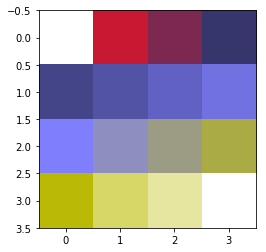

In [21]:
x = np.array([-1.,1.5,4.,7,15.,25.,31.,45.,55.,65.,90.,110.,130.,225.,275.,600.]).reshape(4,4)
print x
plt.imshow(x, cmap=cmap, norm=norm)

In [22]:
diri = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce'
#fili = 'era_interim.PRECTOT.201501.day.nc'

fili = 'MERRA100.prod.PRECTOT.assim.tavg1_2d_flx_Nx.month.197901.nc4'
precip, pproj, pextent, porigin = get_data(os.path.join(diri,fili), 'PRECTOT')


In [23]:
x = xr.DataArray(precip.data, coords=[precip.coords['time'], precip.coords['lon'], precip.coords['lat']],
                 dims=['time', 'lat', 'lon'], attrs=precip.attrs)

KeyError: 'time'

In [24]:
#precMon = x.sum(dim='time')
precMon = precip

In [25]:
#plt.contourf(data, levels=[0.001,5.,10.,15.,20.,25.,30.])
print precMon.sel(lat=slice(None,60)).min()
print precMon.sel(lat=slice(None,60)).max()
#lat = precMon.coords['lat']

<xarray.DataArray 'PRECTOT' ()>
array(2.1483906773717403e-07)
<xarray.DataArray 'PRECTOT' ()>
array(796.7666735649109)


In [26]:
def truncate_colormap( cmap, minval=0.0, maxval=1.0, n=256 ):
    """ mycolormap = truncate_colormap(
            cmap name or file or ndarray,
            minval=0.2, maxval=0.8 ): subset
            minval=1, maxval=0 )    : reverse
    by unutbu http://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    """
    import matplotlib.colors as mcolors 
    
    cmap = get_cmap( cmap )
    name = "%s-trunc-%.2g-%.2g" % (cmap.name, minval, maxval)
    return mcolors.LinearSegmentedColormap.from_list(
        name, cmap( np.linspace( minval, maxval, n )))

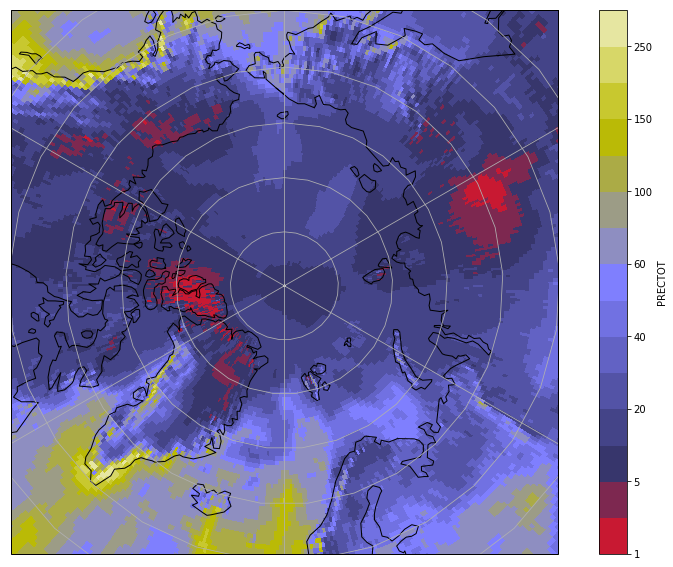

In [27]:
#proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0,
#                                      central_latitude=90.)
proj = ccrs.NorthPolarStereo()
#proj = ccrs.PlateCarree()

#plt.get_cmap('gist_stern')
cmap = truncate_colormap('gist_stern', minval=0.1, maxval=0.9) #set_colormap()
cmap.set_over('white')
cmap.set_under('white')
norm = set_norm(cmap)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=proj) 
ax.set_extent([-180.,180.,60.,90], ccrs.PlateCarree())

precMon.plot(transform=pproj, ax=ax, cmap=cmap, norm=norm)

ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)

plt.show()